In [1]:
# Instalações necessárias ambiente google colab

!pip install shap
!pip install simpletransformers
!pip install -U transformers tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 59.5 MB

### Importações

In [2]:
import pandas as pd
import numpy as np
import scipy

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
import shap
import warnings

import tensorflow as tf
from tensorflow import keras

from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import AutoTokenizer, pipeline

warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"]=(14, 6)

### Carregando e separando base de dados em treino/validação e teste

In [3]:
# Carregando base de dados:

df = pd.read_csv("/content/drive/MyDrive/Dados, ML e IA/Especialização/base_fake_news_trat.csv")
df.head()

,ID,txt_limpo,txt_tratado,txt_stemizado,Categoria,data_proc,Is_Fake
0,1,Kátia Abreu diz que vai colocar sua expulsão e...,katia abreu colocar expulsao moldura reclamar ...,kat abr coloc expulsa mold reclam sen kat abr ...,politica,2017-11-30 00:00:00,1
1,10,"Dr. Ray peita Bolsonaro, chama-o de ""conservad...",ray peita bolsonaro chama conservador fake ent...,ray peit bolsonar cham conserv fak entrev dani...,politica,2017-11-24 00:00:00,1
2,100,Reinaldo Azevedo desmascarado pela Polícia Fed...,reinaldo azevedo desmascarado policia federal ...,reinald azeved desmascar polic feder ferrenh c...,politica,2017-05-23 00:00:00,1
3,1000,Relatório assustador do BNDES mostra dinheiro ...,relatorio assustador bndes mostra dinheiro pub...,relatori assust bnd mostr dinh publ brasil jor...,politica,2017-07-24 00:00:00,1
4,1001,"Radialista americano fala sobre o PT: ""Eles ve...",radialista americano fala vendem ilusao povo b...,radial americ fal vend ilusa pov brasil pens d...,politica,2017-07-25 00:00:00,1


In [4]:
# Separando base em treinamento (75%) e teste (25%):

X = df.drop("Is_Fake", axis=1)
y = df["Is_Fake"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=7)

X_train.head()

,ID,txt_limpo,txt_tratado,txt_stemizado,Categoria,data_proc
4390,1710,"MANAUS, BOA VISTA, NATAL E SÃO PAULO - A morte...",manaus vista natal paulo morte pessoas interva...,manau vist natal paul mort pesso interval sema...,politica,2017-12-29 00:00:00
266,1238,"Senador Randolfe manda recado a Temer: ""Renunc...",senador randolfe manda recado temer renuncie i...,sen randolf mand rec tem renunci imediat manda...,politica,2017-05-17 00:00:00
1377,2239,Cineasta que está produzindo o filme do PT é h...,cineasta produzindo filme herdeira andrade gut...,cineast produz film herd andrad gutierr acion ...,politica,2016-08-31 00:00:00
2129,2916,"Pai de santo contratado pelo PT: ""Dilma não ag...",pai santo contratado dilma aguentara medo suic...,pai sant contrat dilm aguent med suicidi pai s...,tv_celebridades,2016-04-19 00:00:00
5963,3126,Em resposta a embargos de declaração do ex-pre...,resposta embargos declaracao presidente lula j...,respost embarg declaraca presid lul juiz feder...,tv_celebridades,2017-07-18 00:00:00


In [5]:
X_train.shape, X_test.shape

((5400, 6), (1800, 6))

### Análise da quantidade de tokens presente nos textos de treinamento

In [6]:
text_col = "txt_stemizado"
num_tkns = X_train[text_col].apply(lambda t: len(t.split()))
num_tkns.describe()

count    5400.000000
mean      296.905926
std       306.051744
min         4.000000
25%        75.000000
50%       170.000000
75%       427.000000
max      3414.000000
Name: txt_stemizado, dtype: float64

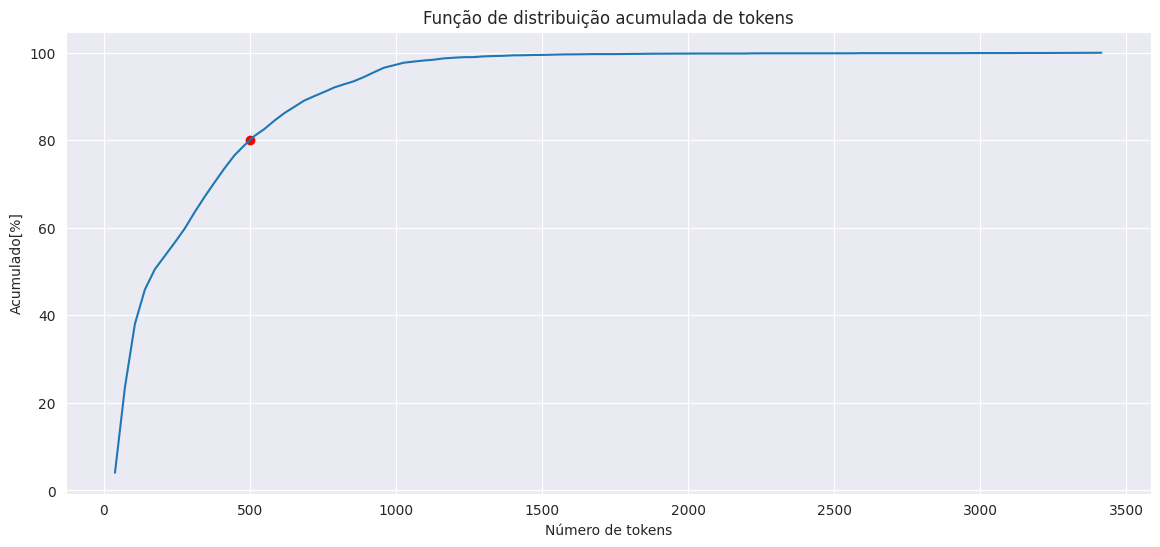

In [7]:
# Função de distribuição acumulada do número de tokens: ~80% dos textos possuem 500 tokens.

count, bins_count = np.histogram(num_tkns.values, bins=100)

pdf = count/np.sum(count)

cdf = np.cumsum(pdf)

plt.plot(bins_count[1:], cdf*100)
plt.title("Função de distribuição acumulada de tokens");
plt.scatter(x=500, y=80, c='red', marker='o')
plt.xlabel("Número de tokens");
plt.ylabel("Acumulado[%]");

In [8]:
limiar = 500
perc = round(100*(num_tkns<=limiar).sum()/num_tkns.size, 2)

print(f"Aproximadamente {perc}[%] dos textos possuem até {limiar} tokens.")

Aproximadamente 80.2[%] dos textos possuem até 500 tokens.


Limitando os textos de treinamento e teste em 500 tokens

In [9]:
X_train[text_col] = X_train[text_col].apply(lambda t: " ".join(t.split()[:limiar]))
X_test[text_col] = X_test[text_col].apply(lambda t: " ".join(t.split()[:limiar]))

### Modelo baseline - Naive Bayes


Validação cruzada estratificada com 5 divisões

In [10]:
folds = StratifiedKFold(n_splits=5,
                        shuffle=True,
                        random_state=42)

scores = {
    "acuracia": [],
    "precisao": [],
    "recall": [],
    "mcc": []
}

for train_idx, val_idx in folds.split(X_train[text_col], y_train):

  X_trn = X_train[text_col].values[train_idx]
  X_val = X_train[text_col].values[val_idx]
  y_trn = y_train.values[train_idx]
  y_val = y_train.values[val_idx]

  countvet = CountVectorizer(ngram_range=(1, 2), max_features=10000)
  countvet.fit(X_trn)

  X_trn_vet = pd.DataFrame(countvet.transform(X_trn).toarray(), columns=countvet.get_feature_names_out())
  X_val_vet = pd.DataFrame(countvet.transform(X_val).toarray(), columns=countvet.get_feature_names_out())

  model = MultinomialNB()
  model.fit(X_trn_vet, y_trn)
  preds = model.predict(X_val_vet)

  scores["acuracia"].append(accuracy_score(y_val, preds))
  scores["precisao"].append(precision_score(y_val, preds))
  scores["recall"].append(recall_score(y_val, preds))
  scores["mcc"].append(matthews_corrcoef(y_val, preds))

Métricas obtidas para cada fold

In [11]:
scores = pd.DataFrame(scores)
scores

,acuracia,precisao,recall,mcc
0,0.862963,0.884314,0.835185,0.727049
1,0.863889,0.906832,0.811111,0.731866
2,0.862963,0.888889,0.829630,0.727544
3,0.839815,0.860511,0.811111,0.680752
4,0.857407,0.890688,0.814815,0.717423


In [12]:
scores.describe()

,acuracia,precisao,recall,mcc
count,5.000000,5.000000,5.000000,5.000000
mean,0.857407,0.886247,0.820370,0.716927
std,0.010164,0.016707,0.011264,0.020900
min,0.839815,0.860511,0.811111,0.680752
25%,0.857407,0.884314,0.811111,0.717423
50%,0.862963,0.888889,0.814815,0.727049
75%,0.862963,0.890688,0.829630,0.727544
max,0.863889,0.906832,0.835185,0.731866


Vetorização completa, treino e teste do modelo

In [13]:
# Vetorização por contagem de tokens - 10000 unigramas e bigramas mais frequentes

countvet = CountVectorizer(ngram_range=(1, 2), max_features=10000)
countvet.fit(X_train[text_col])

X_train_vet = pd.DataFrame(countvet.transform(X_train[text_col]).toarray(), columns=countvet.get_feature_names_out())
X_test_vet = pd.DataFrame(countvet.transform(X_test[text_col]).toarray(), columns=countvet.get_feature_names_out())

X_test_vet.head()

,abaix,abaix integr,abaix trech,abaix vide,abal,abandon,abastec,abastec petrobr,abat,abc,...,zon desmilitar,zon lest,zon nort,zon oest,zon rural,zon sul,zuckerberg,zumb,zung,zveit
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
model = MultinomialNB()

print("====== Treino ========")
model.fit(X_train_vet, y_train)
preds = model.predict(X_test_vet)

print("Coeficiente de correlação de Mattheus: {}\n".format(matthews_corrcoef(y_train, model.predict(X_train_vet))))
print(classification_report(y_train, model.predict(X_train_vet)))

print("====== Teste ========")
print("Coeficiente de correlação de Mattheus: {}\n".format(matthews_corrcoef(y_test, preds)))
print(classification_report(y_test, preds))


====== Treino ========
Coeficiente de correlação de Mattheus: 0.8186272268551337

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2700
           1       0.92      0.90      0.91      2700

    accuracy                           0.91      5400
   macro avg       0.91      0.91      0.91      5400
weighted avg       0.91      0.91      0.91      5400

====== Teste ========
Coeficiente de correlação de Mattheus: 0.7149238221157352

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       900
           1       0.88      0.82      0.85       900

    accuracy                           0.86      1800
   macro avg       0.86      0.86      0.86      1800
weighted avg       0.86      0.86      0.86      1800



Matriz de confusão

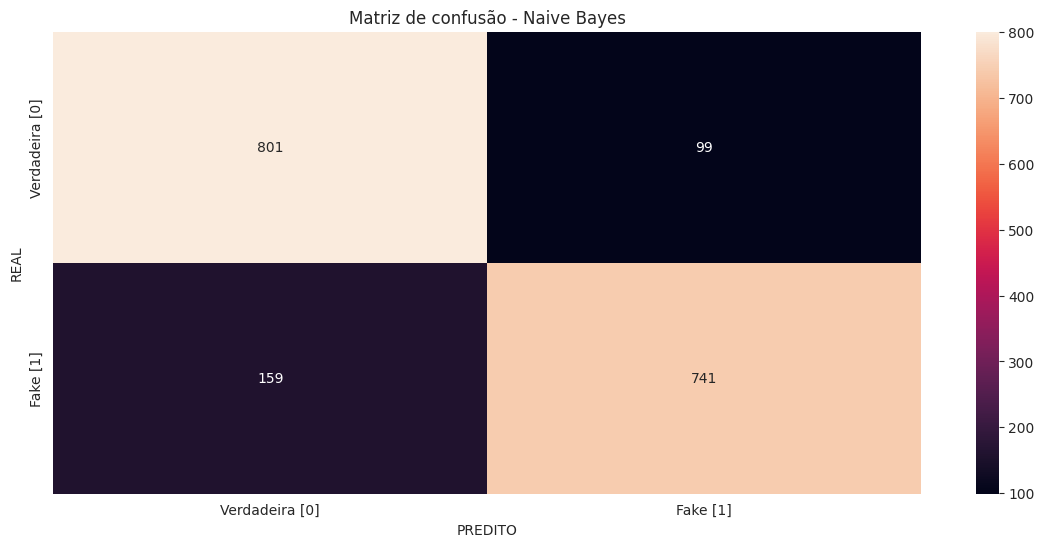

In [15]:
cm = confusion_matrix(y_test, preds)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('PREDITO');
ax.set_ylabel('REAL');
ax.set_title('Matriz de confusão - Naive Bayes');
ax.xaxis.set_ticklabels(['Verdadeira [0]', 'Fake [1]']);
ax.yaxis.set_ticklabels(['Verdadeira [0]', 'Fake [1]']);

### Primeira abordagem: LGBM
Treino e validação do modelo LGBMClassifier com vetorização tfidf dos textos

In [16]:
folds = StratifiedKFold(n_splits=5,
                        shuffle=True,
                        random_state=42)

scores_lgbm = {
    "acuracia": [],
    "precisao": [],
    "recall": [],
    "mcc": []
}

for train_idx, val_idx in folds.split(X_train[text_col], y_train):

  X_trn = X_train[text_col].values[train_idx]
  X_val = X_train[text_col].values[val_idx]
  y_trn = y_train.values[train_idx]
  y_val = y_train.values[val_idx]

  tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000, sublinear_tf=True)
  tfidf.fit(X_trn)

  X_trn_vet = pd.DataFrame(tfidf.transform(X_trn).toarray(), columns=tfidf.get_feature_names_out())
  X_val_vet = pd.DataFrame(tfidf.transform(X_val).toarray(), columns=tfidf.get_feature_names_out())

  model = LGBMClassifier(max_depth=3, n_estimators=200, num_leaves=16, random_state=42, verbosity=-1)
  model.fit(X_trn_vet, y_trn)
  preds = model.predict(X_val_vet)

  scores_lgbm["acuracia"].append(accuracy_score(y_val, preds))
  scores_lgbm["precisao"].append(precision_score(y_val, preds))
  scores_lgbm["recall"].append(recall_score(y_val, preds))
  scores_lgbm["mcc"].append(matthews_corrcoef(y_val, preds))

In [17]:
scores_lgbm = pd.DataFrame(scores_lgbm)
scores_lgbm

,acuracia,precisao,recall,mcc
0,0.954630,0.942342,0.968519,0.909610
1,0.959259,0.949275,0.970370,0.918745
2,0.951852,0.948529,0.955556,0.903728
3,0.957407,0.941071,0.975926,0.915443
4,0.951852,0.942029,0.962963,0.903927


In [18]:
scores_lgbm.describe()

,acuracia,precisao,recall,mcc
count,5.000000,5.000000,5.000000,5.000000
mean,0.955000,0.944650,0.966667,0.910291
std,0.003313,0.003919,0.007747,0.006746
min,0.951852,0.941071,0.955556,0.903728
25%,0.951852,0.942029,0.962963,0.903927
50%,0.954630,0.942342,0.968519,0.909610
75%,0.957407,0.948529,0.970370,0.915443
max,0.959259,0.949275,0.975926,0.918745


Vetorização completa dos textos, treino e teste do modelo

In [19]:

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000, sublinear_tf=True)
tfidf.fit(X_train[text_col])

X_train_vet = pd.DataFrame(tfidf.transform(X_train[text_col]).toarray(), columns=tfidf.get_feature_names_out())
X_test_vet = pd.DataFrame(tfidf.transform(X_test[text_col]).toarray(), columns=tfidf.get_feature_names_out())

X_test_vet.head()

,abaix,abaix integr,abaix trech,abaix vide,abal,abandon,abastec,abastec petrobr,abat,abc,...,zon desmilitar,zon lest,zon nort,zon oest,zon rural,zon sul,zuckerberg,zumb,zung,zveit
0,0.000000,0.000000,0.0,0.0,0.049344,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.026627,0.043453,0.0,0.0,0.000000,0.039004,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.051568,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Validação cruzada, treino e teste do modelo LGBM

model = LGBMClassifier(max_depth=3, n_estimators=200, num_leaves=16, verbosity=-1, random_state=42)

model.fit(X_train_vet, y_train)
preds = model.predict(X_test_vet)

print("====== Treino ========")
print("Coeficiente de correlação de Mattheus: {}\n".format(matthews_corrcoef(y_train, model.predict(X_train_vet))))
print(classification_report(y_train, model.predict(X_train_vet)))

print("====== Teste ========")
print("Coeficiente de correlação de Mattheus: {}\n".format(matthews_corrcoef(y_test, preds)))
print(classification_report(y_test, preds))

====== Treino ========
Coeficiente de correlação de Mattheus: 0.9724389441861266

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2700
           1       0.98      1.00      0.99      2700

    accuracy                           0.99      5400
   macro avg       0.99      0.99      0.99      5400
weighted avg       0.99      0.99      0.99      5400

====== Teste ========
Coeficiente de correlação de Mattheus: 0.9077917870183903

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       900
           1       0.95      0.96      0.95       900

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800



Matriz de confusão e curva ROC-AUC

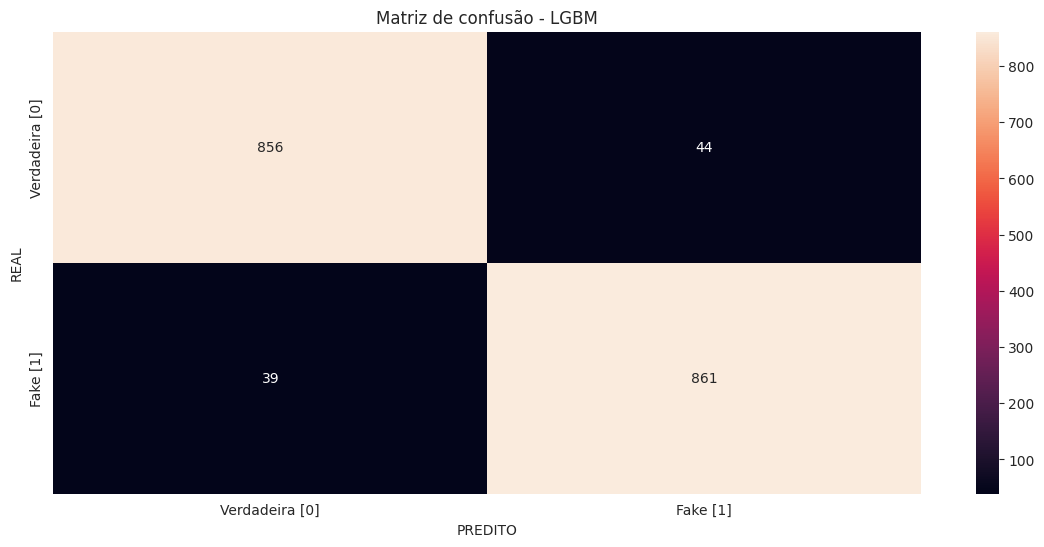

In [21]:
cm = confusion_matrix(y_test, preds)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);ax.set_xlabel('PREDITO');
ax.set_ylabel('REAL');
ax.set_title('Matriz de confusão - LGBM');
ax.xaxis.set_ticklabels(['Verdadeira [0]', 'Fake [1]']);
ax.yaxis.set_ticklabels(['Verdadeira [0]', 'Fake [1]']);

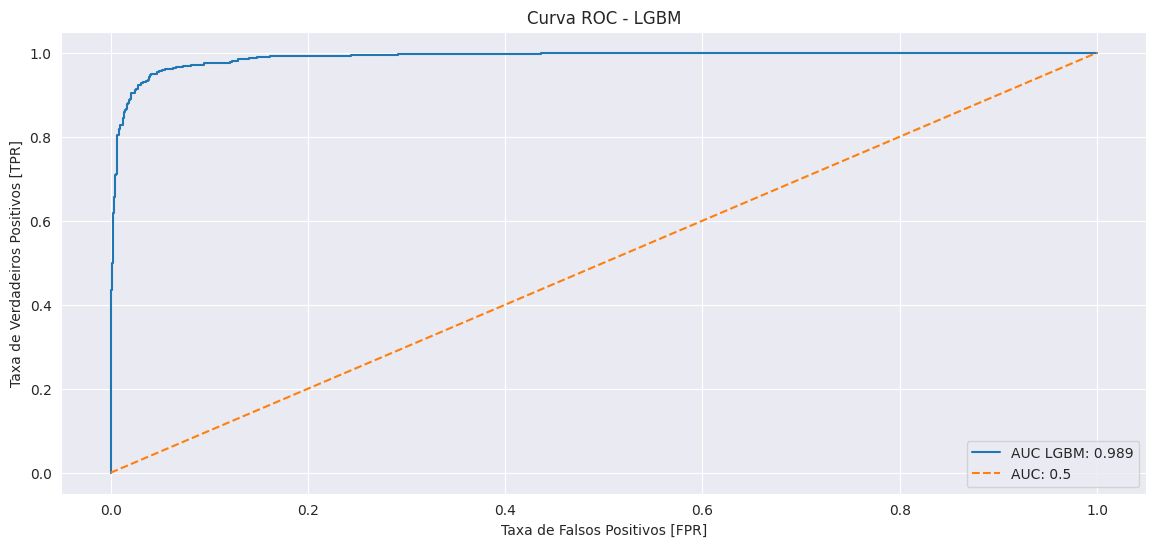

In [22]:
probs = model.predict_proba(X_test_vet)
auc = roc_auc_score(y_test, probs[:, 1])

fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, '--')
plt.title("Curva ROC - LGBM");
plt.xlabel("Taxa de Falsos Positivos [FPR]");
plt.ylabel("Taxa de Verdadeiros Positivos [TPR]");
plt.legend(["AUC LGBM: {:.3f}".format(auc), "AUC: 0.5"])

Explicabilidade do modelo com SHAP

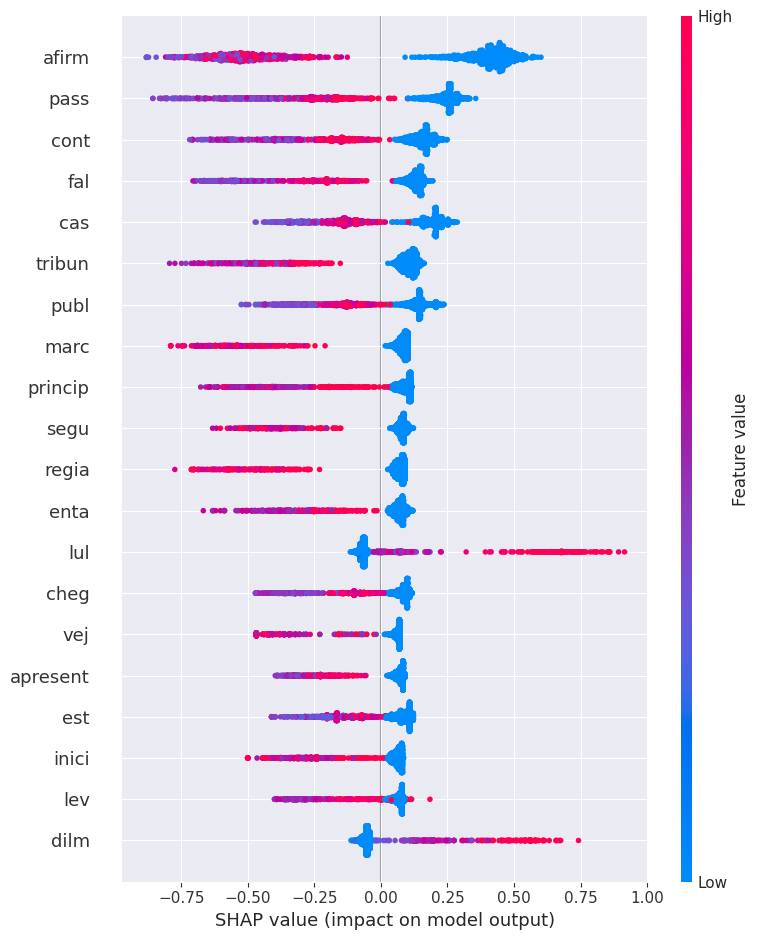

In [23]:
# Avaliando para todos os dados de teste

explainer = shap.TreeExplainer(model)

subset_tp_tn = X_test_vet.loc[preds==y_test.values]
shap_values = explainer.shap_values(subset_tp_tn)
shap.summary_plot(shap_values[1], subset_tp_tn)

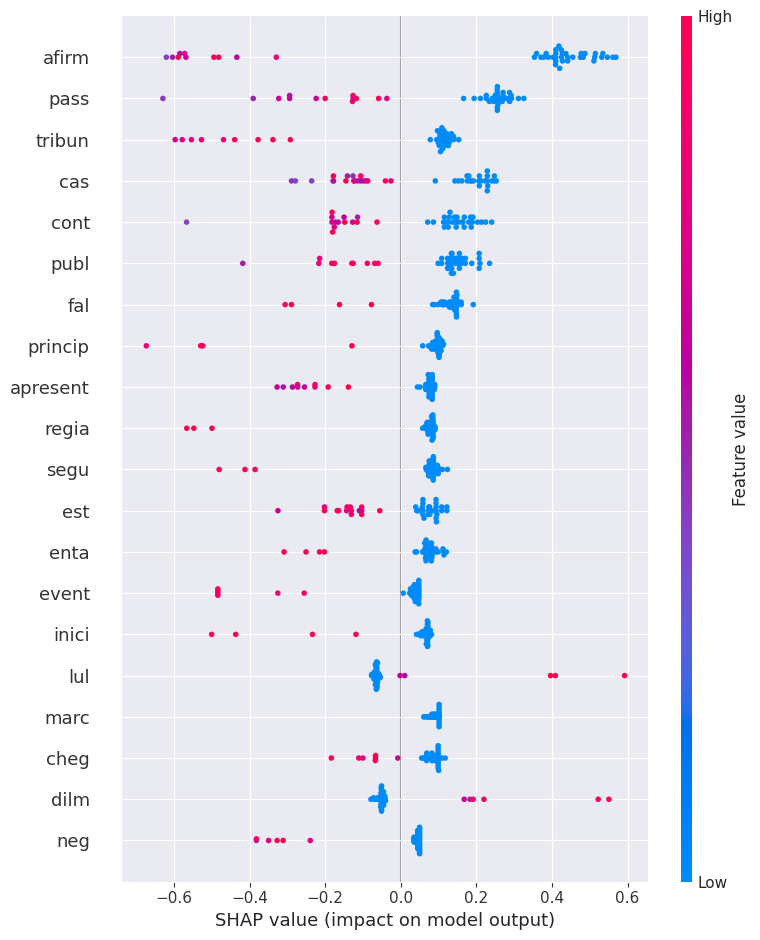

In [24]:
# Avaliando features mais impactantes para os Falsos Positivos

subset_fp = X_test_vet.loc[(preds-y_test.values)==1]
shap_values = explainer.shap_values(subset_fp)
shap.summary_plot(shap_values[1], subset_fp)

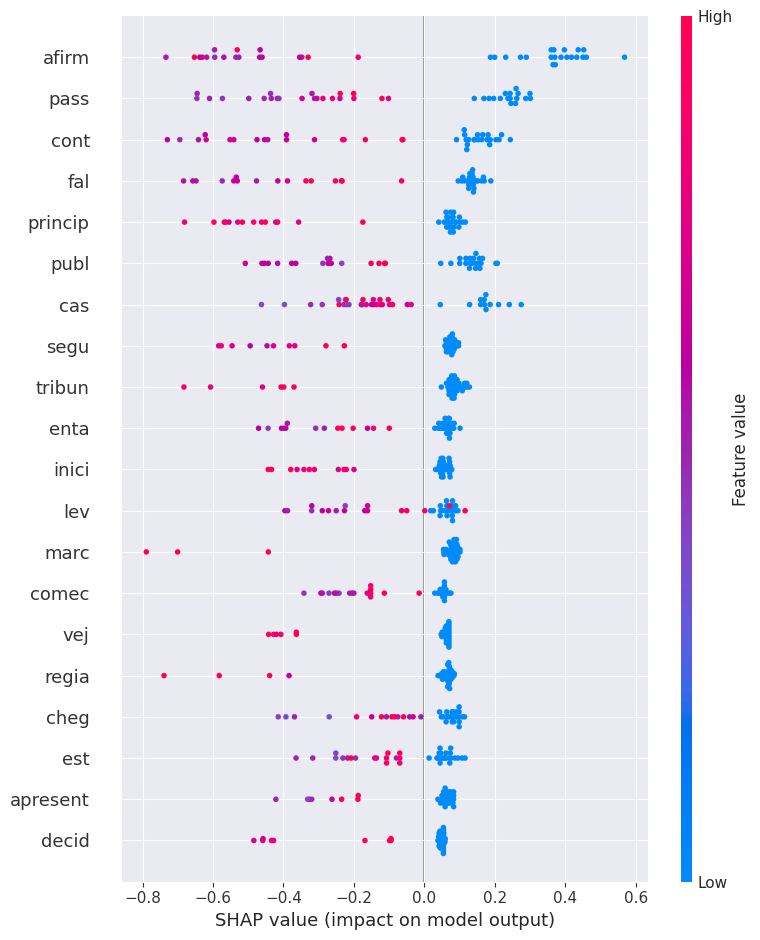

In [25]:
# Avaliando features mais impactantes para os Falsos Negativos

subset_fn = X_test_vet.loc[(y_test.values-preds)==1]
shap_values = explainer.shap_values(subset_fn)
shap.summary_plot(shap_values[1], subset_fn)

### Segunda abordagem: Modelo LSTM, tipo bidirecional


Parâmetros de tokenização, fit do tokenizador e vetorização dos textos

In [26]:
# Definição de variáveis

VOCAB_SIZE = 10000 # Número de tokens únicos a serem considerados
EMBEDDING_DIM = 64 # Dimensão da vetorização dos tokens
MAX_LEN = 500 # Número máximo de tokens a ser considerado por documento (notícia)

In [27]:
# Definição e fit do tokenizador

tokenizador = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizador.fit_on_texts(X_train["txt_stemizado"])
tkns_indices = tokenizador.word_index
list(tkns_indices.items())[:15]

[('presid', 1),
 ('brasil', 2),
 ('lul', 3),
 ('govern', 4),
 ('cas', 5),
 ('feder', 6),
 ('tem', 7),
 ('afirm', 8),
 ('ministr', 9),
 ('publ', 10),
 ('est', 11),
 ('poli', 12),
 ('ped', 13),
 ('pass', 14),
 ('pesso', 15)]

In [28]:
# Vetorização e limitação do tamanho dos vetores

seq_train = tokenizador.texts_to_sequences(X_train["txt_stemizado"])
seq_test = tokenizador.texts_to_sequences(X_test["txt_stemizado"])

padded_train = keras.preprocessing.sequence.pad_sequences(seq_train, maxlen=MAX_LEN, truncating='post')
padded_test = keras.preprocessing.sequence.pad_sequences(seq_test, maxlen=MAX_LEN, truncating='post')

Montagem da estrutura do modelo

In [29]:
# Arquitetura e definição do modelo LSTM

try:
  del lstm_model
  print("Deletado!")
except:
  pass

input_model = keras.Input(shape=(MAX_LEN, ), name='input_layer')
embedding_layer = keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, name="embedding_layer")(input_model)
lstm_layer = keras.layers.Bidirectional(keras.layers.LSTM(32), name="Bi_LSTM_layer")(embedding_layer)
dense_layer = keras.layers.Dense(16, activation='relu', name="hidden_layer")(lstm_layer)

output_model = keras.layers.Dense(1, activation='sigmoid', name="output_layer")(dense_layer)

lstm_model = keras.Model(inputs=input_model, outputs=output_model, name="Modelo_LSTM")

lstm_model.summary()

Model: "Modelo_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 500)]             0         
                                                                 
 embedding_layer (Embedding  (None, 500, 64)           640000    
 )                                                               
                                                                 
 Bi_LSTM_layer (Bidirection  (None, 64)                24832     
 al)                                                             
                                                                 
 hidden_layer (Dense)        (None, 16)                1040      
                                                                 
 output_layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 665889 (2.54 MB)
Trainable params: 665889

Compilação e treino/validacao do modelo

In [30]:
# Divisão dos dados:

padded_trn, padded_val, y_trn, y_val = train_test_split(padded_train, y_train, test_size=0.15,
                                                        shuffle=True,
                                                        stratify=y_train,
                                                        random_state=42)

In [31]:
# Definição dos callbacks:

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only='True',
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights='True',
    min_delta=0.2
)

In [32]:
lstm_model.compile(optimizer='Adam',
                   loss="binary_crossentropy",
                   metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])


with tf.device('/gpu:0'):
  hist = lstm_model.fit(x=padded_trn,
            y=y_trn,
            epochs=10,
            batch_size=64,
            validation_data=(padded_val, y_val),
            callbacks = [model_checkpoint, early_stop],
  )

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.5550 - accuracy: 0.6832 - precision: 0.6365 - recall: 0.8545
Epoch 1: val_loss improved from inf to 0.40958, saving model to best_model.h5
72/72 [==============================] - 30s 258ms/step - loss: 0.5550 - accuracy: 0.6832 - precision: 0.6365 - recall: 0.8545 - val_loss: 0.4096 - val_accuracy: 0.8963 - val_precision: 0.9326 - val_recall: 0.8543
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.2362 - accuracy: 0.9429 - precision: 0.9365 - recall: 0.9503
Epoch 2: val_loss improved from 0.40958 to 0.25181, saving model to best_model.h5
72/72 [==============================] - 15s 205ms/step - loss: 0.2362 - accuracy: 0.9429 - precision: 0.9365 - recall: 0.9503 - val_loss: 0.2518 - val_accuracy: 0.9173 - val_precision: 0.8756 - val_recall: 0.9728
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.1226 - accuracy: 0.9675 - precision: 0.9710 - recall: 0.9638
Epoch 3: val_loss i

Text(0, 0.5, 'Custo')

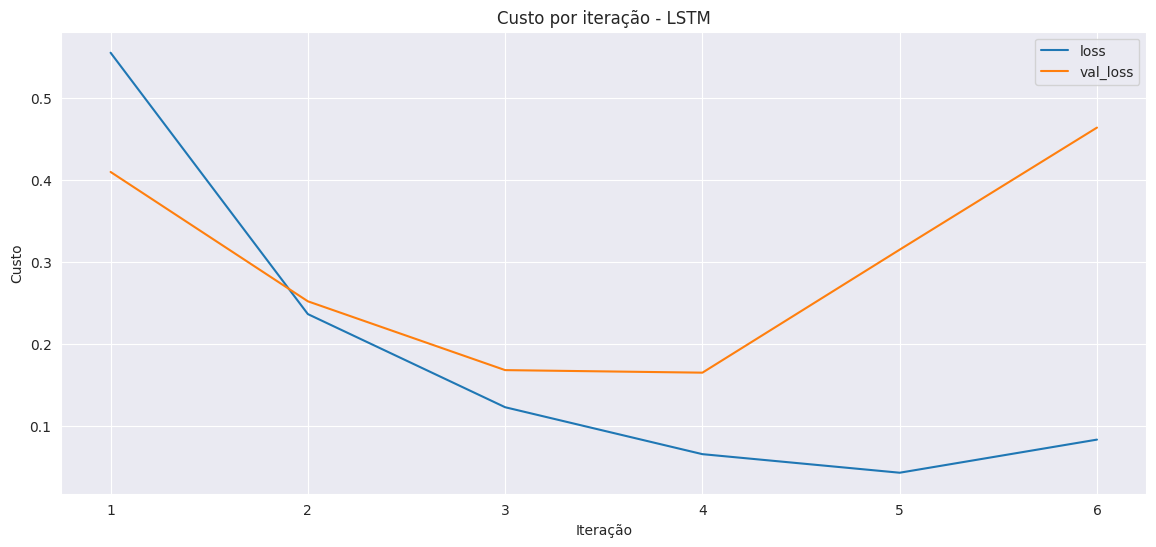

In [33]:
plt.figure()
plt.plot(list(range(1, len(hist.history["loss"])+1)), hist.history["loss"])
plt.plot(list(range(1, len(hist.history["loss"])+1)),hist.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title("Custo por iteração - LSTM")
plt.xlabel("Iteração")
plt.ylabel("Custo")

In [34]:
probs_train = lstm_model.predict(padded_trn)
probs_val = lstm_model.predict(padded_val)
probs_test = lstm_model.predict(padded_test)

57/57 [==============================] - 1s 12ms/step


In [35]:
print("Coeficiente de correlação de Mattheus: {}\n".format(matthews_corrcoef(y_trn, np.round(probs_train))))
print(classification_report(y_trn, np.round(probs_train)))

print("Coeficiente de correlação de Mattheus: {}\n".format(matthews_corrcoef(y_val, np.round(probs_val))))
print(classification_report(y_val, np.round(probs_val)))

print("Coeficiente de correlação de Mattheus: {}\n".format(matthews_corrcoef(y_test, np.round(probs_test))))
print(classification_report(y_test, np.round(probs_test)))

Coeficiente de correlação de Mattheus: 0.9630113247784878

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2295
           1       0.98      0.99      0.98      2295

    accuracy                           0.98      4590
   macro avg       0.98      0.98      0.98      4590
weighted avg       0.98      0.98      0.98      4590

Coeficiente de correlação de Mattheus: 0.8938298851737464

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       405
           1       0.95      0.95      0.95       405

    accuracy                           0.95       810
   macro avg       0.95      0.95      0.95       810
weighted avg       0.95      0.95      0.95       810

Coeficiente de correlação de Mattheus: 0.8823289795943555

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       900
           1       0.93      0.95      0.94       900

    a

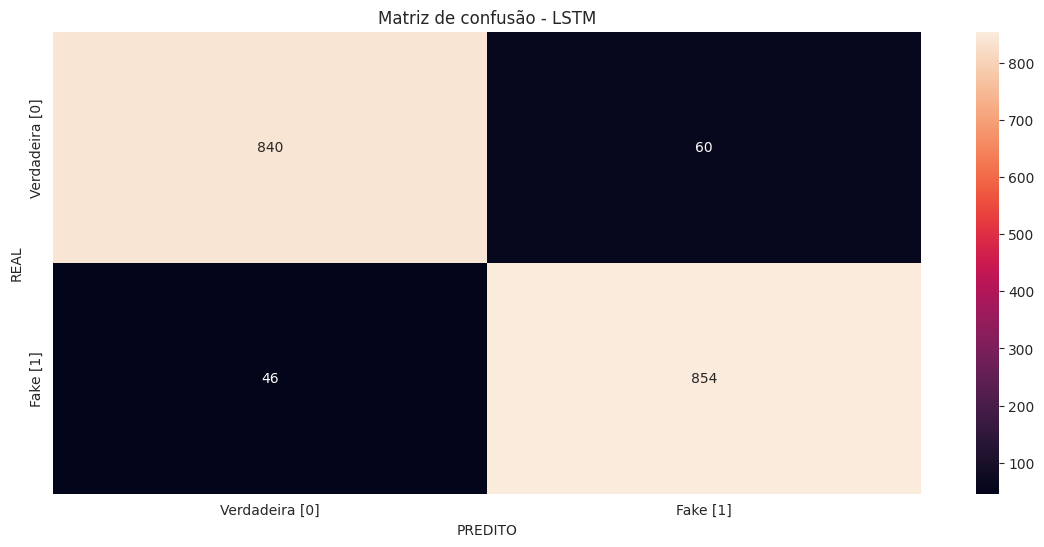

In [36]:
cm = confusion_matrix(y_test, np.round(probs_test))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('PREDITO');
ax.set_ylabel('REAL');
ax.set_title('Matriz de confusão - LSTM');
ax.xaxis.set_ticklabels(['Verdadeira [0]', 'Fake [1]']);
ax.yaxis.set_ticklabels(['Verdadeira [0]', 'Fake [1]']);

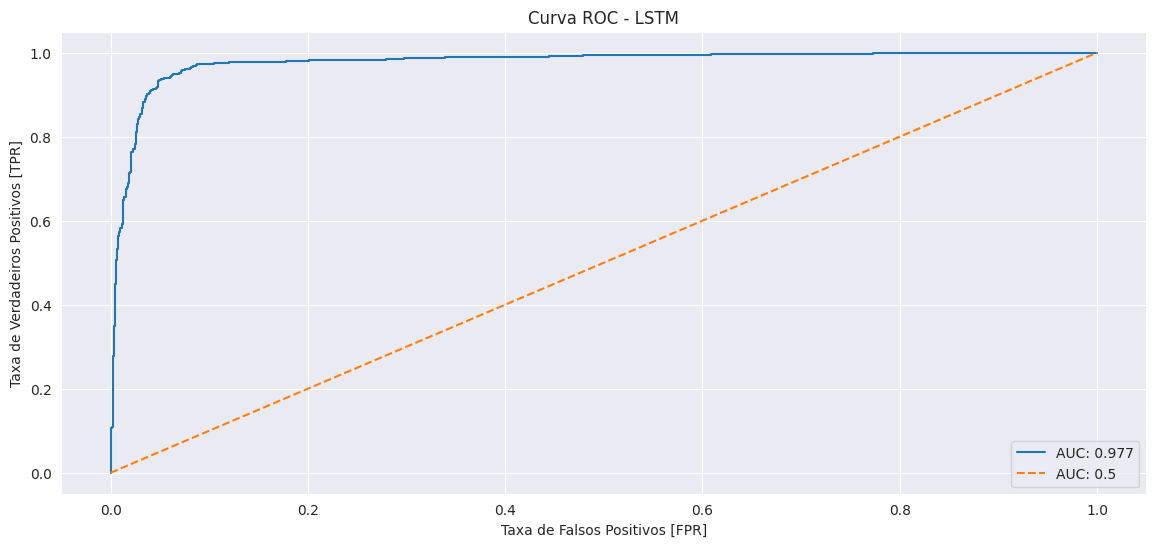

In [37]:
auc = roc_auc_score(y_test, probs_test)

fpr, tpr, thresholds = roc_curve(y_test, probs_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, '--')
plt.title("Curva ROC - LSTM");
plt.xlabel("Taxa de Falsos Positivos [FPR]");
plt.ylabel("Taxa de Verdadeiros Positivos [TPR]");
plt.legend(["AUC: {:.3f}".format(auc), "AUC: 0.5"])

### Terceira abordagem - BERT para classificação

Preparo dos dados de treinamento e teste para correto refinamento do modelo

In [38]:
df_train = pd.DataFrame()
df_train["text"] = X_train["txt_limpo"].values
df_train["labels"] = y_train.values

df_test = pd.DataFrame()
df_test["text"] = X_test["txt_limpo"].values
df_test["labels"] = y_test.values

df_test.head()

,text,labels
0,Quem são os juízes que decidirão o futuro de L...,0
1,Os projetos de privatização para melhorar o de...,0
2,O ex-presidente Lula ‘atentou contra a ordem p...,0
3,EUA lançam míssil nuclear da base de North Van...,1
4,Ex-primeira dama sofreu parada cardíaca. . Ve...,1


Separação de uma parte da base de treinamento em validação

In [39]:
df_train, df_eval, _, _ = train_test_split(df_train, y_train, test_size=0.15,
                                           stratify=y_train,
                                           shuffle=True,
                                           random_state=7)

Definição de hiperparâmetros e configurações do modelo

In [40]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

train_args= ClassificationArgs(
    use_multiprocessing = False,
    use_multiprocessing_for_evaluation = False,
    reprocess_input_data = False,
    overwrite_output_dir = True,
    max_seq_length = 500,
    num_train_epochs = 5,
    evaluate_during_training = True,
    do_lower_case = True,
    no_cache = True,
    manual_seed = 1,
    evaluate_during_training_verbose = True,
    save_eval_checkpoints = False,
    save_model_every_epoch = False
)

Instanciando o modelo e realizando o treinamento

In [41]:
model_bert = ClassificationModel('bert', 'neuralmind/bert-base-portuguese-cased', args=train_args, use_cuda=True)

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [42]:
out_model = model_bert.train_model(df_train, eval_df=df_eval, accuracy=accuracy_score, precision=precision_score, recall=recall_score, mcc=matthews_corrcoef)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/574 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/574 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/574 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/574 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/574 [00:00<?, ?it/s]

Métricas do modelo refinado nos dados de treinamento, validação e teste

In [43]:
result, model_outputs, wrong_predictions = model_bert.eval_model(df_train, accuracy=accuracy_score, precision=precision_score, recall=recall_score, mcc=matthews_corrcoef)
result

Running Evaluation:   0%|          | 0/574 [00:00<?, ?it/s]

{'mcc': 1.0,
 'tp': 2295,
 'tn': 2295,
 'fp': 0,
 'fn': 0,
 'auroc': 1.0,
 'auprc': 0.9999999999999999,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'eval_loss': 1.569052467949446e-05}

In [44]:
result, model_outputs, wrong_predictions = model_bert.eval_model(df_eval, accuracy=accuracy_score, precision=precision_score, recall=recall_score, mcc=matthews_corrcoef)
result

Running Evaluation:   0%|          | 0/102 [00:00<?, ?it/s]

{'mcc': 0.9852933165854874,
 'tp': 399,
 'tn': 405,
 'fp': 0,
 'fn': 6,
 'auroc': 0.9998902606310014,
 'auprc': 0.9998921304469467,
 'accuracy': 0.9925925925925926,
 'precision': 1.0,
 'recall': 0.9851851851851852,
 'eval_loss': 0.045426909830055984}

In [45]:
result, model_outputs, wrong_predictions = model_bert.eval_model(df_test, accuracy=accuracy_score, precision=precision_score, recall=recall_score, mcc=matthews_corrcoef)
result

Running Evaluation:   0%|          | 0/225 [00:00<?, ?it/s]

{'mcc': 0.9811843998435278,
 'tp': 886,
 'tn': 897,
 'fp': 3,
 'fn': 14,
 'auroc': 0.9995018518518518,
 'auprc': 0.9995444368380518,
 'accuracy': 0.9905555555555555,
 'precision': 0.9966254218222722,
 'recall': 0.9844444444444445,
 'eval_loss': 0.06688631249798668}

Matriz de confusão e curva ROC-AUC

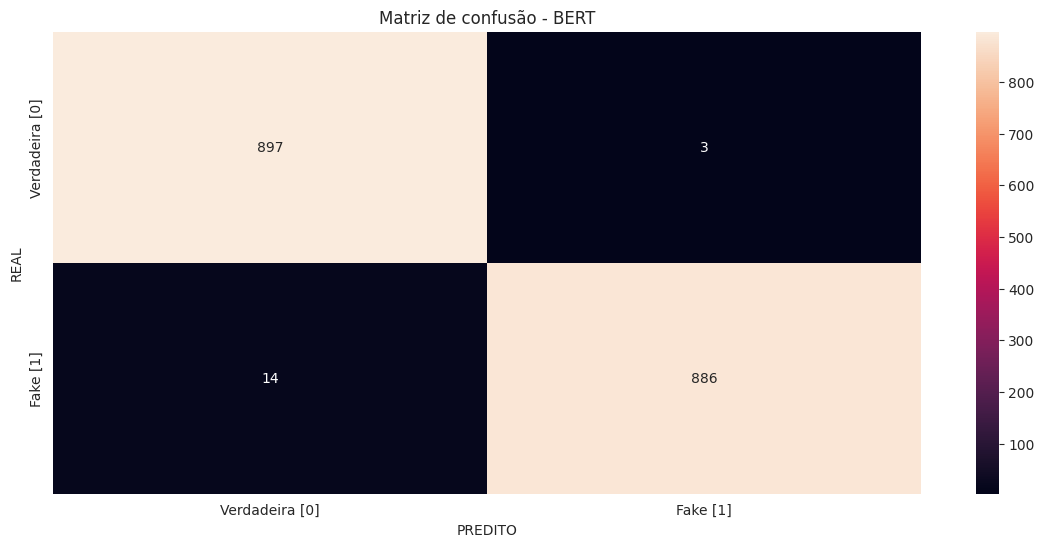

In [46]:
cm = [[result['tn'], result['fp']],
      [result['fn'], result['tp']]]

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('PREDITO');
ax.set_ylabel('REAL');
ax.set_title('Matriz de confusão - BERT');
ax.xaxis.set_ticklabels(['Verdadeira [0]', 'Fake [1]']);
ax.yaxis.set_ticklabels(['Verdadeira [0]', 'Fake [1]']);

In [47]:
sigmoid = lambda x: 1/(1+np.exp(-x))

probs = sigmoid(model_outputs[:, 1])

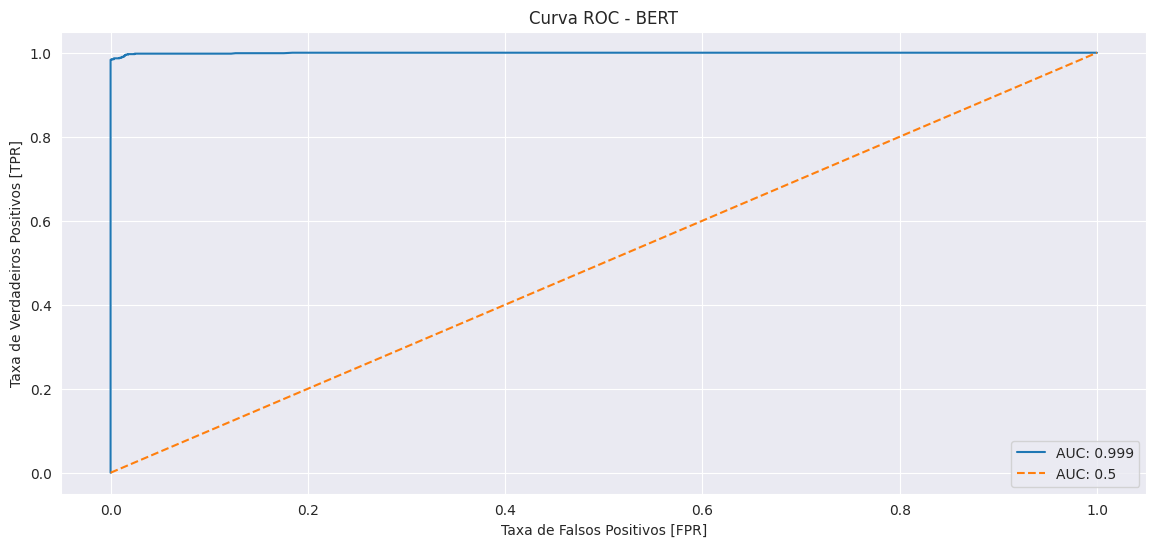

In [48]:
auc = roc_auc_score(y_test, probs)

fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.figure()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, '--')
plt.title("Curva ROC - BERT");
plt.xlabel("Taxa de Falsos Positivos [FPR]");
plt.ylabel("Taxa de Verdadeiros Positivos [TPR]");
plt.legend(["AUC: {:.3f}".format(auc), "AUC: 0.5"])